# Regresión Geográfica Ponderada (RGP o GWR)



In [1]:
import numpy as np
import libpysal as ps
from mgwr.gwr import GWR, MGWR
from mgwr.sel_bw import Sel_BW
from osgeo import ogr
import geopandas as gp
import matplotlib.pyplot as plt
import matplotlib as mpl
from dbfread import DBF
import pandas as pd

## En qgis hice los centreoides de las localidades de los datos porque ocupaba las coordenadas para hacer la regresión

In [55]:
df=  gp.read_file('/home/noxd/Home2/datos/Indice y Grado de Marginación municipal, por localidad y ageb, 2010-2015/shape/IMM2015.shp')
df1=  gp.read_file('/home/noxd/Home2/datos/Indice y Grado de Marginación municipal, por localidad y ageb, 2010-2015/shape/IMM_2015.shp')


In [56]:
df.head()

,CVE_MUN,NOM_MUN,POB_TOT,ANALF,SPRIM,OVSDE,OVSEE,OVSAE,VHAC,OVPT,PL_5000,PO2SM,IM,GM,CVE_ENT,NOM_ENT,xcoord,ycoord,geometry
0,1,17001,0.0,17772.0,9.07,21.45,2.89,0.38,3.98,31.65,5.46,68.46,48.64,-0.530000000000000,Bajo,17,-99.386685,18.590000,POINT (-99.38668 18.59000)
1,2,17002,0.0,22079.0,6.30,20.12,1.41,1.84,17.54,32.27,9.35,57.97,46.38,-0.420000000000000,Medio,17,-98.894505,18.935045,POINT (-98.89450 18.93505)
2,3,17003,0.0,35689.0,10.29,26.18,3.16,0.68,15.53,35.43,8.00,48.04,69.64,-0.060000000000000,Medio,17,-98.752114,18.525239,POINT (-98.75211 18.52524)
3,4,17004,0.0,85521.0,6.96,20.50,2.22,0.75,4.28,30.69,6.14,51.48,51.12,-0.640000000000000,Bajo,17,-98.977985,18.717244,POINT (-98.97798 18.71724)
4,5,17005,0.0,9768.0,9.12,28.80,5.20,1.03,1.92,29.49,3.96,100.00,59.54,-0.210000000000000,Medio,17,-99.445777,18.731830,POINT (-99.44578 18.73183)


In [57]:
df.shape

(2857, 19)

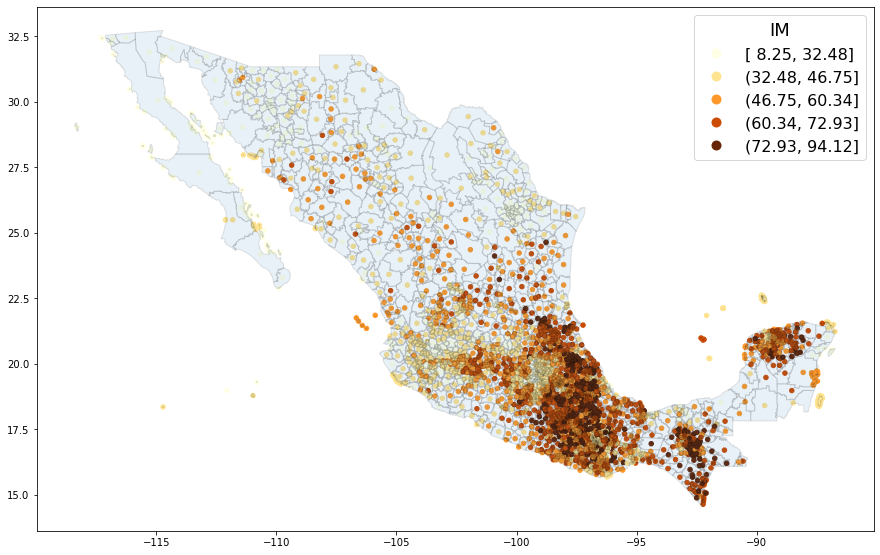

In [77]:
leg_kwds={'title':'IM','frameon':False,'fontsize': 16,'title_fontsize':18  ,'frameon': True}

fig, ax = plt.subplots(figsize=(15,10))
df.plot(column = 'IM',cmap='YlOrBr',scheme='Fisher_Jenks',  markersize=20, legend=True, 
        legend_kwds=leg_kwds,ax=ax)
df1.plot(ax=ax,  alpha=0.1, edgecolor='k')


 ## La regresión es el indice de marginación contra la población que vive en localidades con menos de 5 mil personas, porcentaje de la población que gana menos de 2 salarios minimos y % pob. sin educación primaria 
 


In [59]:
#preparamos y normalizamos los datos y coordenadas
g_y = df['IM'].values.reshape((-1,1))
g_X = df[['PL_5000', 'PO2SM','SPRIM']].values
u = df['xcoord']
v = df['ycoord']
g_coords = list(zip(u,v))

g_X = (g_X - g_X.mean(axis=0)) / g_X.std(axis=0)

g_y = g_y.reshape((-1,1))

g_y = (g_y - g_y.mean(axis=0)) / g_y.std(axis=0)

In [60]:
#Calibrate GWR model
gwr_selector = Sel_BW(g_coords, g_y, g_X, kernel='gaussian',spherical=True)
#bw_min varia dependiendo de los datos
gwr_bw = gwr_selector.search(bw_min=80,criterion='AICc')
print(gwr_bw)

81.0


In [61]:
gwr_results = GWR(g_coords, g_y, g_X, gwr_bw,constant=True,spherical=True).fit()

In [5]:
help(GWR)

Help on class GWR in module mgwr.gwr:

class GWR(spglm.glm.GLM)
 |  GWR(coords, y, X, bw, family=<spglm.family.Gaussian object at 0x7fa89a1eaf90>, offset=None, sigma2_v1=True, kernel='bisquare', fixed=False, constant=True, spherical=False, hat_matrix=False)
 |  
 |  Geographically weighted regression. Can currently estimate Gaussian,
 |  Poisson, and logistic models(built on a GLM framework). GWR object prepares
 |  model input. Fit method performs estimation and returns a GWRResults object.
 |  
 |  Parameters
 |  ----------
 |  coords        : array-like
 |                  n*2, collection of n sets of (x,y) coordinates of
 |                  observatons; also used as calibration locations is
 |                  'points' is set to None
 |  
 |  y             : array
 |                  n*1, dependent variable
 |  
 |  X             : array
 |                  n*k, independent variable, exlcuding the constant
 |  
 |  bw            : scalar
 |                  bandwidth value consisti

In [62]:
gwr_results.summary()

Model type                                                         Gaussian
Number of observations:                                                2857
Number of covariates:                                                     4

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                           1487.263
Log-likelihood:                                                   -3121.333
AIC:                                                               6250.666
AICc:                                                              6252.687
BIC:                                                             -21215.563
R2:                                                                   0.479
Adj. R2:                                                              0.479

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

In [63]:
R2=gwr_results.localR2

In [64]:
df.insert(df.shape[1], 'R2',R2, True)

Text(0.5, 1.0, 'R2 local de la RPG clasificado por cuantiles')

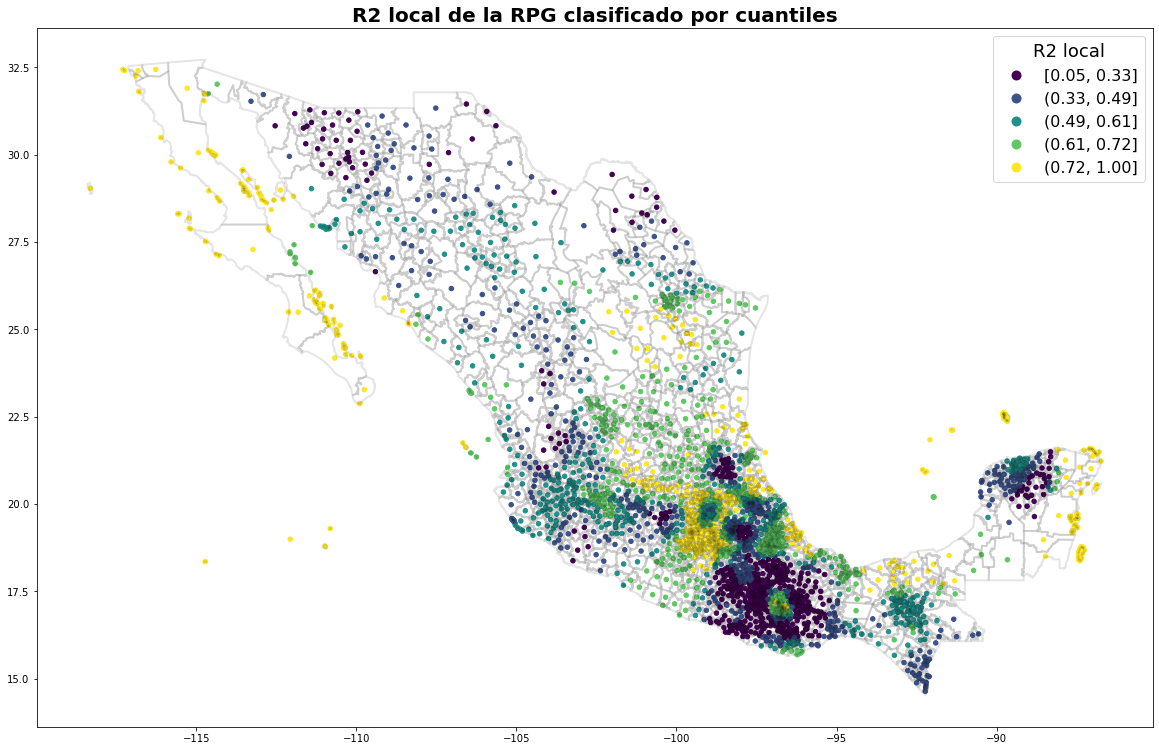

In [65]:
leg_kwds={'title':'R2 local','frameon':False,'fontsize': 16,'title_fontsize':18  ,'frameon': True}
fig, ax = plt.subplots(figsize = (20,16)) 
df.plot(column = 'R2',cmap='viridis',scheme='quantiles',  markersize=20, legend=True, 
        legend_kwds=leg_kwds,ax=ax)
df1.geometry.boundary.plot(color=None,edgecolor='k',  alpha=0.1, linewidth = 2, zorder=1, ax=ax)
plt.title("R2 local de la RPG clasificado por cuantiles", fontsize=20, fontweight='bold',zorder=2)


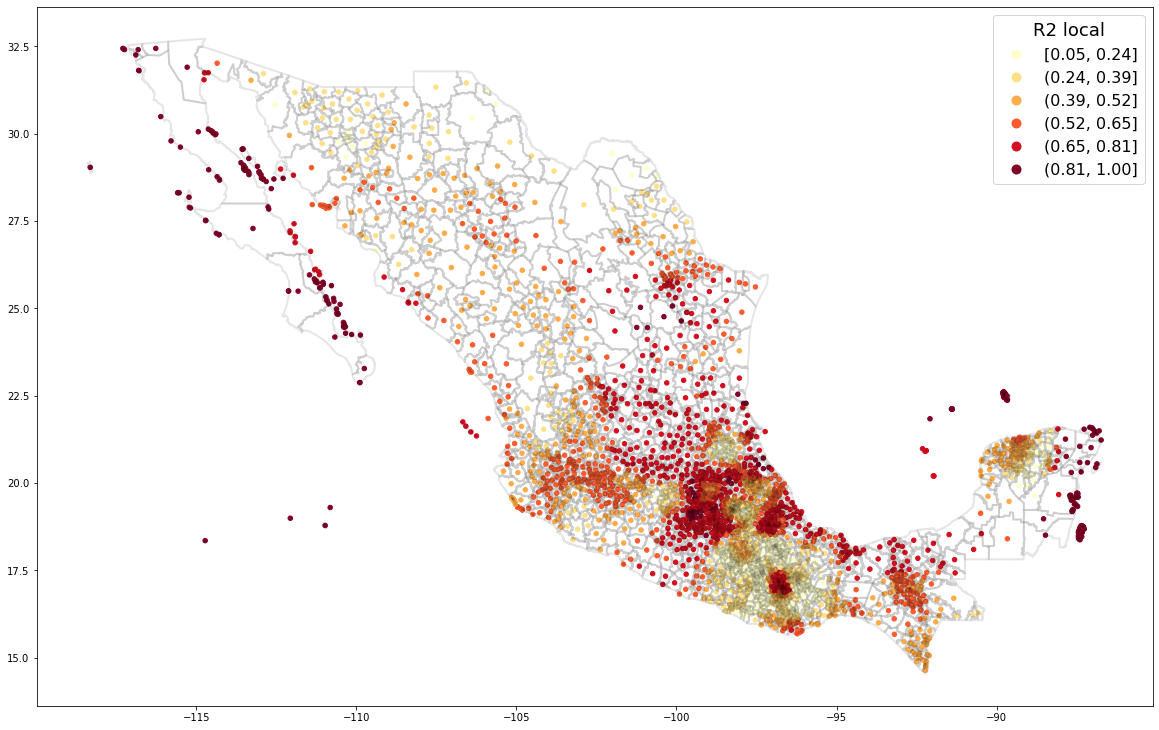

In [76]:
leg_kwds={'title':'R2 local','frameon':False,'fontsize': 16,'title_fontsize':18  ,'frameon': True}
fig, ax = plt.subplots(figsize = (20,16)) 
df.plot(column = 'R2',cmap='YlOrRd',scheme='Fisher_Jenks', k=6,  markersize=20, legend=True, 
        legend_kwds=leg_kwds,ax=ax)
df1.geometry.boundary.plot(color=None,edgecolor='k',  alpha=0.1, linewidth = 2, zorder=1, ax=ax)
#plt.title("R2 local de la RPG clasificado por umbrales naturales Fisher Jenks", fontsize=20, fontweight='bold',zorder=2)



In [ ]:
leg_kwds={'title':'R2 local','frameon':False,'fontsize': 16,'title_fontsize':18  ,'frameon': True}
fig, ax = plt.subplots(figsize = (20,16)) 
df.plot(column = 'R2',cmap='inferno',scheme='equal_interval', k=7,  markersize=20, legend=True, 
        legend_kwds=leg_kwds,ax=ax)
df1.geometry.boundary.plot(color=None,edgecolor='k',  alpha=0.1, linewidth = 2, zorder=1, ax=ax)
#plt.title("R2 local de la RPG clasificado por intervalos iguales", fontsize=20, fontweight='bold',zorder=2)


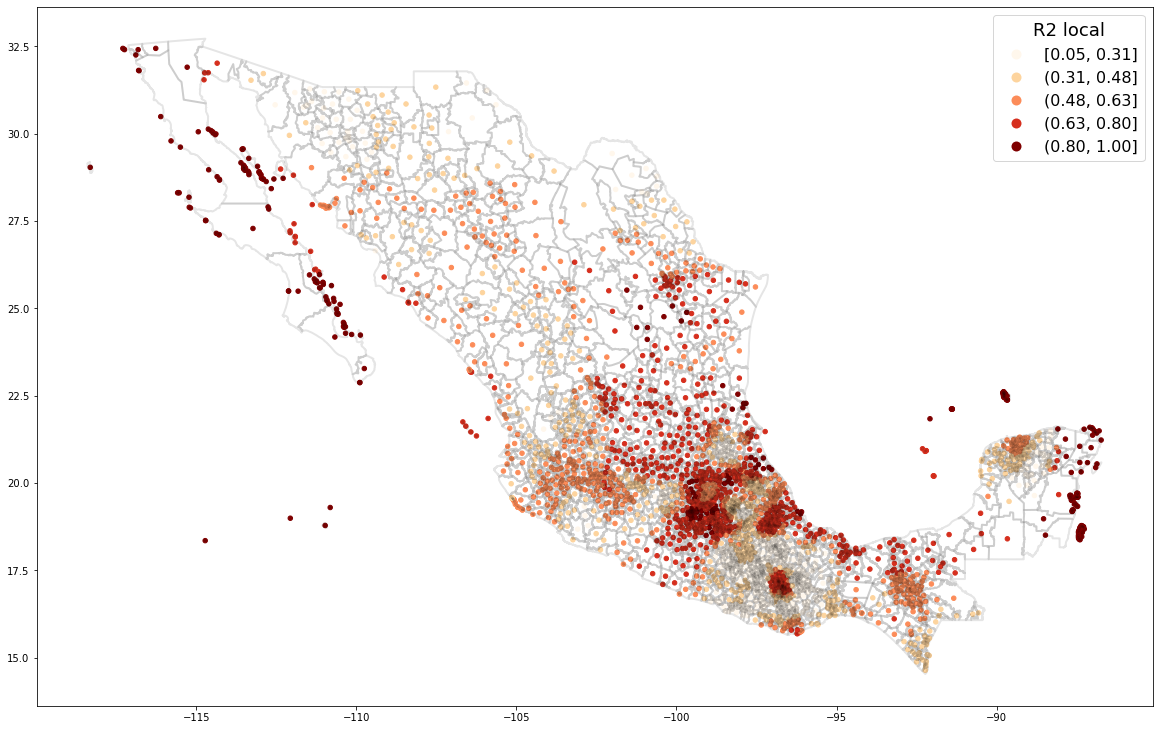

In [74]:
leg_kwds={'title':'R2 local','frameon':False,'fontsize': 16,'title_fontsize':18  ,'frameon': True}
fig, ax = plt.subplots(figsize = (20,16)) 
df.plot(column = 'R2',cmap='OrRd',scheme='NaturalBreaks', k=5,  markersize=20, legend=True, 
        legend_kwds=leg_kwds,ax=ax)
df1.geometry.boundary.plot(color=None,edgecolor='k',  alpha=0.1, linewidth = 2, zorder=1, ax=ax)
#plt.title("R2 local de la RPG clasificado por Natural Breaks", fontsize=20, fontweight='bold',zorder=2)

Text(0.5, 1.0, 'R2 local de la RPG clasificado por desv. estandar')

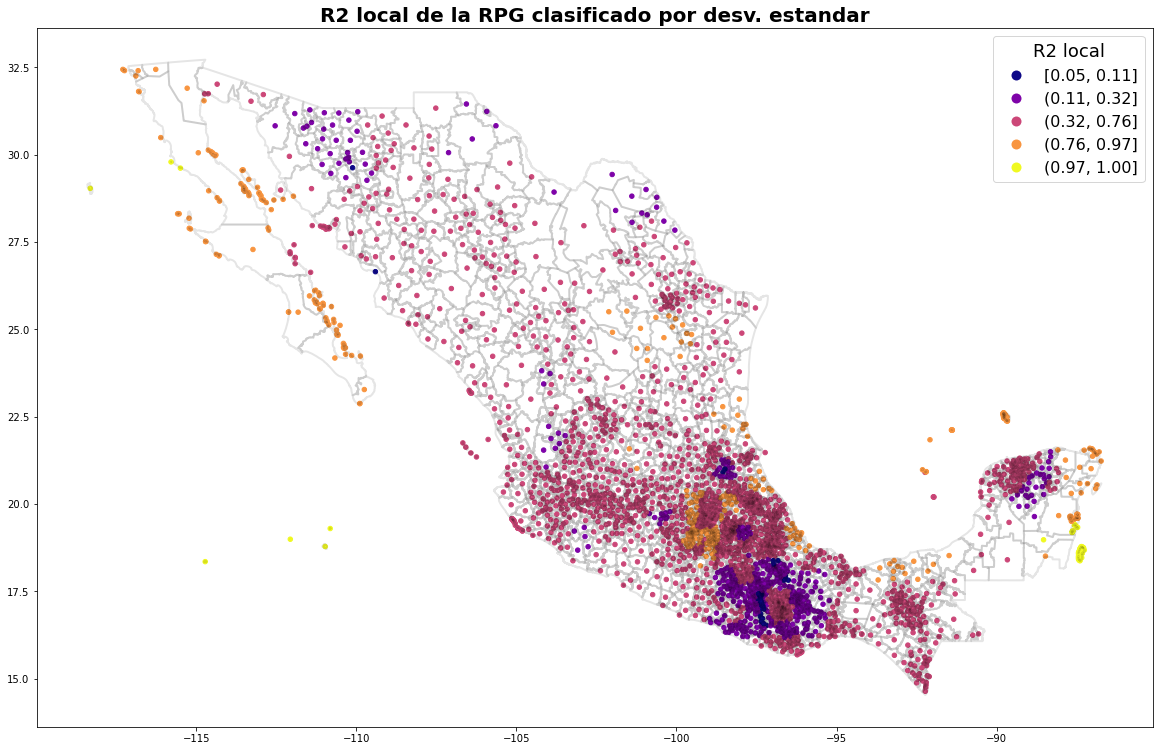

In [71]:
leg_kwds={'title':'R2 local','frameon':False,'fontsize': 16,'title_fontsize':18  ,'frameon': True}
fig, ax = plt.subplots(figsize = (20,16)) 
df.plot(column = 'R2',cmap='plasma',scheme='StdMean', k=5,  markersize=20, legend=True, 
        legend_kwds=leg_kwds,ax=ax)
df1.geometry.boundary.plot(color=None,edgecolor='k',  alpha=0.1, linewidth = 2, zorder=1, ax=ax)
plt.title("R2 local de la RPG clasificado por desv. estandar", fontsize=20, fontweight='bold',zorder=2)

Text(0.5, 1.0, 'R2 local de la RPG clasificado por mapeo de caja')

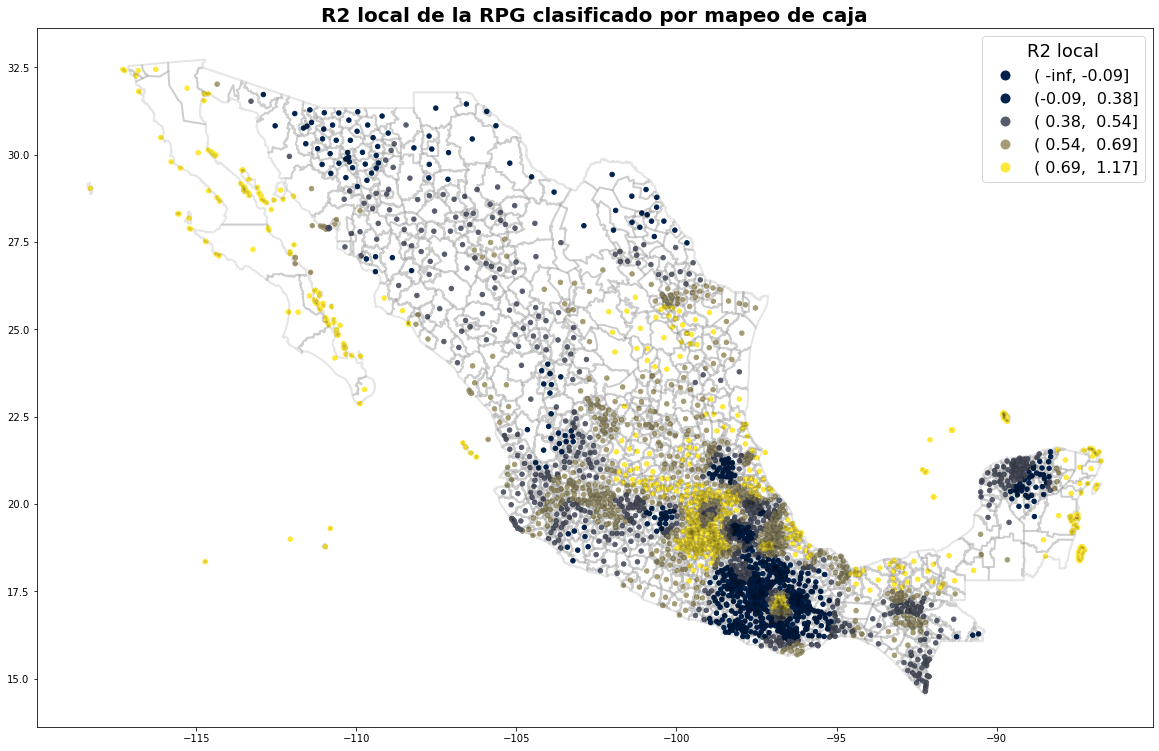

In [72]:
leg_kwds={'title':'R2 local','frameon':False,'fontsize': 16,'title_fontsize':18  ,'frameon': True}
fig, ax = plt.subplots(figsize = (20,16)) 
df.plot(column = 'R2',cmap='cividis',scheme='BoxPlot', k=5,  markersize=20, legend=True, 
        legend_kwds=leg_kwds,ax=ax)
df1.geometry.boundary.plot(color=None,edgecolor='k',  alpha=0.1, linewidth = 2, zorder=1, ax=ax)
plt.title("R2 local de la RPG clasificado por mapeo de caja", fontsize=20, fontweight='bold',zorder=2)